<a href="https://colab.research.google.com/github/s0phia-/AI_challenge_day/blob/main/nondeterminism_in_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implications of Non-Determinism in Neural Network Optimisation

Neural networks are powerful but unpredictable, with small changes in factors like parameter initialisation or data pre-processing leading to significant variations in performance. A recent paper shows that many sources of non-determinism can produce similar levels of variability, even from seemingly trivial changes like altering a single neuron’s initialisation. These surprising findings challenge assumptions about neural network stability and raise critical questions about reproducibility and explainability. For this year’s AI Challenge Day, our table will reproduce the most important findings in the paper, to validate their claims and explore their broader implications.

Participants will work in small groups or individually to replicate the paper’s experiments, breaking the work into subtasks managed using agile project management and a shared scrum board. Tasks will include reproducing key results, investigating additional sources of non-determinism, and discussing the impact on AI research. We ask that participants are familiar with Python, PyTorch and bring a laptop, and we will contact them beforehand with setup instructions. The paper, which participants are encouraged to review before the event, can be found here: https://proceedings.mlr.press/v139/summers21a/summers21a.pdf. By the end of the session, we aim to verify the findings and generate new insights into managing non-determinism in training AI systems.

## The Plan for Today

### Objective
Today, we aim to replicate the results of the experiment described in Section 3.2 of the paper, which investigates the effects of non-determinism and instability on training a ResNet model for classifying the CIFAR-10 dataset. Specifically, our goal is to reproduce **Table 1** from the paper.

### Experiment Overview
The authors identify several sources of non-determinism in neural network optimisation:
1. **Parameter Initialisation**
2. **Data Shuffling**
3. **Data Augmentation**
4. **Low-level cuDNN Operations**

Each of these sources is detailed in Section 3 of the paper. Relevant explanations are also provided in their respective sections within this notebook.

#### Experimental Setup
The experiment involves:
- Fixing certain sources of non-determinism while varying others (using seeds).
- Training the ResNet model over 100 runs.
- Measuring how the varied sources of non-determinism influence training outcomes.

The detailed methodology is outlined in Section 3.1 of the paper and is summarised in the **"Protocol for Testing Effects of Non-determinism"** section of this notebook.

### Evaluation Metrics
The authors use two metrics to evaluate instability:
1. **Performance Variability**: Variability in model accuracy (e.g. cross-entropy or classification accuracy) along with the standard deviation of these metrics across 100 runs.
2. **Representation Diversity**: The average disagreement between pairs of models. Higher disagreement corresponds to greater diversity and variability.

### Provided Resources
To streamline the process, we have provided base code with the following flow:
1. **Package Setup**: Install and configure necessary packages in your virtual environment.
2. **Data Loading**: Load and preprocess the CIFAR-10 dataset.
3. **Model Definition**: Define the ResNet architecture.
4. **Model Training**: Train the ResNet model.
5. **Output Visualisation**: Visualise and analyse the model outputs.

### Tasks for Participants

Your task is to complete the missing code by implementing a series of functions, working in pairs or individually. Each pair/individual will be responsible for implementing a specific function, following agile project management principles.

We will use a shared Git repository to collaborate and ensure consistency across implementations. Participants will:

1. **Plan and Assign Tasks**: Use agile techniques to break down the work into manageable subtasks (e.g. functions), assigning them to individuals or pairs.
2. **Develop and Modify Code**: Each function includes a skeleton definition that can be customized as needed.
3. **Coordinate and Collaborate**: Communicate with others at your table or via Git to synchronize development efforts and resolve dependencies.

Collaboration and clear communication are key to ensuring that all components integrate seamlessly by the end of the session.

#### Core Functions
1. **Fixing/Varying Sources of Non-determinism:**
   - `param_init`: Initialises the model with a given seed.
   - `data_shuffle`: Shuffles the data using a given seed.
   - `data_augmentation`: Augments the data using a given seed.
   - `cuDNN`: Seeds the cuDNN backend.

2. **Experiment Flow:**
   - `nondeterminism_experiment`: Orchestrates the experiment by fixing some sources of non-determinism and varying others. Trains 100 models using 100 different seeds.

3. **Evaluation Functions:**
   - `performance_variance`: Computes the average accuracy and cross-entropy across the trained models.
   - `pairwise_disagreement`: Measures pairwise disagreement between models, assessing how their predictions vary for each input.

### Final Steps
Using the functions above, the notebook will:
1. Reproduce the various combinations of determinism and non-determinism as detailed in **Table 3**.
2. Generate and analyse the reproduced table to validate the findings.

### Optional Additional Work
If time permits, explore the additional tasks provided at the end of the notebook for deeper insights and further experimentation.

### Important Notes:
- **Google Colab Usage**: Everyone is advised to use Google Colab for running this experiment to ensure an efficient and compatible environment.
- **GPU Enablement**: Be sure to enable GPU support in Google Colab by selecting **Runtime > Change runtime type > Hardware accelerator > GPU** for faster model training and experimentation.

## Setup and Preparation

In [1]:
### Environment Setup ###

%pip install -q torch torchvision
%pip install matplotlib
%pip install numpy
%pip install tabulate

In [2]:
#### Load Data ###

import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
### Define ResNet model ###

import torch.nn as nn
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


def conv3x3(in_channels, out_channels, stride=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
      padding=1, bias=False)


class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    # Both self.conv1 and self.downsample layers downsample the input when
    # stride != 1
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)
      identity = torch.cat((identity, torch.zeros_like(identity)), 1)

    out += identity
    out = self.relu(out)

    return out


class ResNet(nn.Module):

  def __init__(self, block, layers, channels_per_block=None, num_classes=10):
    super(ResNet, self).__init__()

    if channels_per_block is None:
      channels_per_block = [16, 32, 64]
    if len(layers) != len(channels_per_block):
      raise ValueError('number of layers and channels per block must be equal')
    self.num_layers = sum(layers)
    self.inplanes = channels_per_block[0]
    self.conv1 = conv3x3(3, channels_per_block[0])
    self.bn1 = nn.BatchNorm2d(channels_per_block[0])
    self.relu = nn.ReLU(inplace=True)
    self.layers = []
    for i, (num_channels, num_blocks) in enumerate(zip(channels_per_block,
                                                       layers)):
      self.layers.append(self._make_layer(block, num_channels, num_blocks,
                                          stride=(1 if i == 0 else 2)))
      self.add_module('layer%d' % i, self.layers[-1])

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(channels_per_block[-1], num_classes)

    for _, m in sorted(self.named_modules()):
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Zero-initialize the last BN in each residual branch so that the residual
    # branch starts with zeros, and each residual block behaves like an
    # identity. This improves the model by 0.2~0.3% according to
    # https://arxiv.org/abs/1706.02677
    for _, m in sorted(self.named_modules()):
      if isinstance(m, BasicBlock):
        nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1:
      downsample = nn.Sequential(
        nn.AvgPool2d(1, stride=stride),
        nn.BatchNorm2d(self.inplanes),
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for _ in range(1, blocks):
      layers.append(block(planes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    for layer in self.layers:
      x = layer(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

Using cuda device


In [9]:
### Helper functions ###

import matplotlib.pyplot as plt
import numpy as np

def train(model, epochs=1000):
    """
    Training loop using fixed hyper-parameters. Returns the trained model.
    """

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

    # PATH = './cifar_net.pth'
    # torch.save(model.state_dict(), PATH)

    return model

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualise_model(model, device, num_images=4):
    """
    Visualizes the model's predictions on a few test images.
    """

    # get test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # print images
    imshow(torchvision.utils.make_grid(images))

    # show ground truth labels
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}'
                                    for j in range(num_images)))

    # show predicted labels
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_images)))

### Example initialisation, training and visualisation

[1,  2000] loss: 2.213
[1,  4000] loss: 2.104
[1,  6000] loss: 2.042
[1,  8000] loss: 1.984
[1, 10000] loss: 1.915
[1, 12000] loss: 1.859
Finished Training


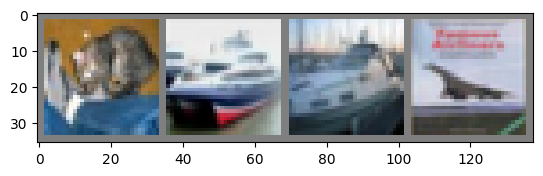

GroundTruth:  cat   ship  ship  plane
Predicted:  frog  truck plane plane


In [10]:
model = ResNet(BasicBlock, [2, 2, 2], [16, 32, 64]).to(device)
train(model, epochs=1)
visualise_model(model, device)

## Non-Determinisism Functions

### Parameter Initialisation

*When training a model, parameters without preset values are initialized randomly according to a given distribution, e.g. a zero-mean Gaussian with variance determined by the number of input connections to the layer (Glorot & Bengio, 2010; He et al., 2015).*

In [ ]:
### todo: control random initialisation of parameters

def param_init(seed: int) -> ResNet:
    """
    Initialize model parameters with a fixed seed.

    Args:
        seed: int, seed for random number generator
    """

    # model = ResNet(BasicBlock, [2, 2, 2], [16, 32, 64]).to(device)
    ### optional: print model ###
    # print(model)

    return model

### Data Shuffling

*In stochastic gradient descent, the gradient is approximated on a random subset of examples, commonly implemented by using small batches of data iteratively in a shuffled training dataset (Bottou, 2012). Shuffling may happen either once, before training, or in between each
epoch of training, the variant we use in this work.*

In [ ]:
### todo: control randomness in data shuffling

# Note:
    # The current notebook structure assumes the data is only shuffled once at the beginning of the training loop.
    # This is not the case in the original code, where the data is shuffled at the beginning of each epoch.

def data_shuffle(train_loader: torch.utils.data.DataLoader, seed: int) -> torch.utils.data.DataLoader:
    """
    Shuffles the data using the given seed.

    Args:
        train_loader: DataLoader object containing the training data to be shuffled.
        seed: int, seed for random number generator

    Returns:
        The shuffled data.
    """

    return train_loader

### Data Augmentation

*A common practice, data augmentation refers to randomly altering each training example to artificially expand the training dataset (Shorten & Khoshgoftaar, 2019). For example, randomly flipping images encourages invariance to left/right orientation.*

In [ ]:
### todo: control randomness in data augmentation

def data_augmentation(train_loader: torch.utils.data.DataLoader, seed: int) -> torch.utils.data.DataLoader:
    """
    Augments the data in the train_loader using random transformations controlled by seed.

    Args:
        train_loader: DataLoader object containing the training data to be augmented.
        seed: int, seed for random number generator

    Returns:
        DataLoader object containing the augmented data
    """

    return train_loader

### Low-level Operations (cuDNN)

*Often underlooked, many libraries that deep learning frameworks are built on, such as cuDNN (Chetlur et al., 2014), typically run nondeterministically in order to increase the speed of their operations. This nondeterminism is small when evaluated in the context of a single operation — in one test we performed it caused an output difference of 0.003%. In the case of cuDNN, the library we test, it is possible to disable nondeterministic behavior at a speed penalty on the order of ∼15%. However, unlike other nondeterminism sources, it is not possible to “seed” this; it is only possible to turn it on or off.*

In [ ]:
### todo: seed cudnn

def cuDNN(seed: int):
    """
    Seeds the cuDNN backend for deterministic behaviour.

    Args:
        seed: int, seed for cuDNN backend.
    """

    pass

### Chaning the Initialisation of a Single Bit

*First we deterministically train a simple ResNet-14 model on CIFAR-10, achieving a test cross-entropy of $0.3519$ and accuracy of $90.0\%$. Then, we train another model in an identical fashion, with exactly equal settings for all sources of nondeterminism, but one extremely small change: we randomly pick a single weight in the first layer and change its value by the smallest possible amount in a 32-bit floating point representation, i.e. an addition or subtraction of a single bit in the least-significant digit. As an example, this could change a value from $-0.0066514308$ to $-0.0066514313$, a difference on the order of $5 \cdot 10^{-10}$.*

In [ ]:
### todo: change 1 bit in network

def one_bit_param_init(model: ResNet, seed: int) -> ResNet:
    """
    Change one bit in the weights of the model.

    Args:
        model: The model to modify.
        seed: The seed used to choose bit and change.

    Returns:
        The modified model.
    """

    return model

## Protocol for Testing Effects of Nondeterminism

*Our protocol for testing the effects of sources of nondeterminism is based on properly controlling for each source.
Formally, suppose there are $N$ sources of nondeterminism, with source $i$ controlled by seed $S_i$.
To test the effect of source $i$, we keep all values $\{S_j\}_{j \neq i}$ set to a constant, and vary $S_i$ with $R$ different values, where $R$ is the number of independent training runs performed. For sources of nondeterminism which cannot be effectively seeded, such as cuDNN, we indicate one of these values as the deterministic value, which it must be set to when varying the other sources of nondeterminism.*

*For example, denote $S_1$ the seed for random parameter initialization, $S_2$ for training data shuffling, and $S_3$ for cuDNN, where $S_3 = 1$ is the deterministic value for cuDNN.
To test the effect of random parameter initialization, with a budget of $R = 100$ training runs, we set $S_3$ to the deterministic value of $1$, $S_2$ to an arbitrary constant (typically 1 for simplicity), and test 100 different values of $S_1$. All together, this corresponds to training models for each of $(S_1, S_2, S_3) \in \{(i, 1, 1)\}_{i=1}^{100}$.*

*Note that it is also possible to test the effect of several sources of nondeterminism in tandem this way, e.g. by considering $(S_1, S_2, S_3) \in \{(i, i, 0)\}_{i=1}^{R}$ to measure the joint effect of all three sources in this example.*

In [ ]:
### Train and test loop (outline only) ###

def nondeterminism_experiment(*args: str) -> tuple[float, ...]:
    """
    100 training runs fixing some aspects of nondeterminism and varying others with seed.

    Args:
        *args: list of strings to dictate aspects of non-determinism to vary.

    Returns:
        accuracy_mean: mean accuracy of models
        accuracy_std: standard deviation of accuracy of models
        cross_entropy_mean: mean cross-entropy of models
        cross_entropy_std: standard deviation of cross-entropy of models
        pairwise_disagreement: average pairwise disagreement between models
    """

    models = []

    for seed in range(1, 101):

        ### To Do ###
        # Control for different aspects of non-determinism...
        # Fix seed for some and vary seed for others...
        # if 'param_init' in args: ...

        # Train model
        model = train(model)

        # Save model for evaluation
        models.append(model)

    # Evaluate models
    accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std = performance_variance(models)
    pairwise_disagreement = pairwise_diagreement(models)

    return accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement




### Performance Variability

*To measure variability of a particular evaluation metric (e.g. cross-entropy or accuracy for classification), we calculate the standard deviation (across all $R = 100$ models) of the metric.*

In [ ]:
def performance_variance(models: list[ResNet]) -> tuple[float, ...]:
    """
    Args:
        models: list of models to evaluate

    Returns:
        accuracy_mean: mean of accuracy of models
        accuracy_std: standard deviation of accuracy of models
        cross_entropy_mean: mean of cross entropy of models
        cross_entropy_std: standard deviation of cross entropy of models
    """

    # return accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std
    pass

### Representation Diversity

*We also examine differences in the representation of trained models, complementary to variability in test set performance ---
this allows us to differentiate cases where two sources of nondeterminism have similar performance variability but actually produce models with disparate amounts of representational similarity.*

*We consider the average disagreement between pairs of models, with higher disagreement corresponding to higher diversity and variability. This considers only the argmax of a model's predictions, which makes it a limited but interpretable.
This metric has also been used recently to compare similarity in the context of network ensembles (Fort et al., 2019).*

In [ ]:
def pairwise_diagreement(models:list[ResNet]) -> float:
    """
    Args:
        models: list of models

    Returns:
        float: average pairwise disagreement between each pair of models
    """

    # return pairwise_diagreement
    pass

### Recreating the table results from the paper

In [ ]:
from tabulate import tabulate

# Run experiments and collect results
results = []

# Parameter initialisation
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('param_init')
results.append(["Parameter Initialization",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Data shuffling
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('data_shuffle')
results.append(["Data Shuffling",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Data augmentation
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('data_augmentation')
results.append(["Data Augmentation",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# cuDNN
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('cuDNN')
results.append(["cuDNN",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Data shuffling + cuDNN
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('data_shuffle', 'cuDNN')
results.append(["Data Shuffling + cuDNN",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Data shuffling + data augmentation + cuDNN
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('data_shuffle', 'data_augmentation', 'cuDNN')
results.append(["Data Shuffling + Aug. + cuDNN",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Parameter initialisation + data shuffling + data augmentation + cuDNN
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('param_init', 'data_shuffle', 'data_augmentation', 'cuDNN')
results.append(["All Nondeterminism Sources",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Print the table
headers = ["Nondeterminism Source", "Accuracy SD (%)", "Cross-Entropy SD", "Pairwise Disagree (%)"]
print(tabulate(results, headers=headers, tablefmt="grid"))

### Recreating the single parameter change experiment

In [ ]:
# Run experiments and collect results
results = []

# Single parameter initialisation
accuracy_mean, accuracy_std, cross_entropy_mean, cross_entropy_std, pairwise_disagreement = nondeterminism_experiment('single_param_init')
results.append(["Single Parameter Initialization",
                f"{accuracy_mean:.2f} ± {accuracy_std:.2f}",
                f"{cross_entropy_mean:.4f} ± {cross_entropy_std:.4f}",
                f"{pairwise_disagreement:.1f}"])

# Print the table
headers = ["Nondeterminism Source", "Accuracy SD (%)", "Cross-Entropy SD", "Pairwise Disagree (%)"]
print(tabulate(results, headers=headers, tablefmt="grid"))

## Additional Work

If time permits, we will:

1. **Discuss the Implications of Non-determinism**: Explore how non-determinism affects neural network training, reproducibility, and explainability.
2. **Investigate Additional Sources of Non-determinism**: Examine other factors, such as stochastic regularization, or experiment with different combinations of known sources.

### Stochastic Regularisation

*"Some types of regularization, such as Dropout (Srivastava et al., 2014), take the form of stochastic operations internal to a model during training. Other instances of this include DropConnect (Wan et al., 2013) and variable length backpropagation through time (Merity et al., 2017), among many others."*

In [ ]:
def stochastic_operations():
    pass